# Forward Simulation of UXO Detection

In [71]:
# SimPEG functionality
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# Common Python functionality
import os
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

# import uxo object
from UXO_object import UXO_object

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define a 1D Layered Model

In [72]:
conductivity_background = 1e-1
conductivity_uxo = 6.2e6

In [73]:
# create a sample uxo object
uxo = UXO_object(np.array([0.0, 0.0, -1.0]), 0.5, 0.2, 0, 0)
intersects = np.array(uxo.get_vertical_intersects(0,0))

print(f'Intersects at: {intersects}')

Intersects at: [-0.5 -1.5]


In [74]:
# Define layer thicknesses (m)
layer_thicknesses = np.abs(intersects)

# Define layer conductivities (S/m)
layer_conductivities = np.r_[conductivity_background, conductivity_uxo, conductivity_background]

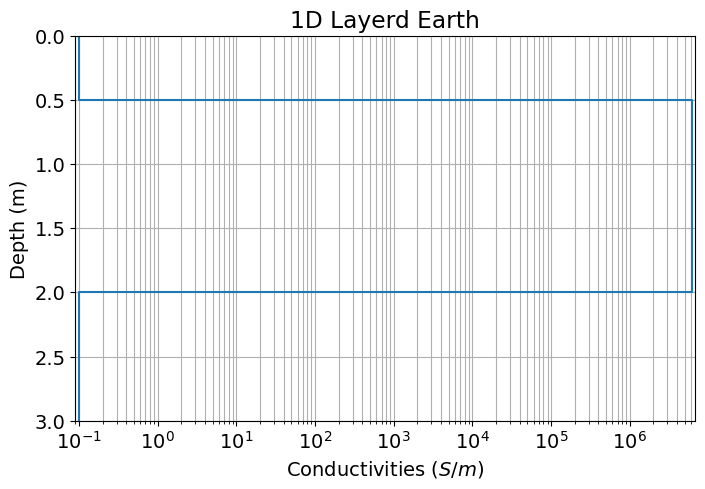

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax)
ax.grid(which="both")
ax.set_xlabel(r"Conductivities ($S/m$)")
ax.set_ylim([3, 0])
ax.set_title("1D Layerd Earth")
plt.show()

In [76]:
# LOG-RESISTIVITY MODEL
log_conductivities_model = np.log(layer_conductivities)

# Define the Mappings
log_conductivities_map = maps.ExpMap(nP=len(layer_thicknesses)+1)

## Define Survey

In [77]:
# Source properties
frequencies = 5*np.logspace(-3, 5, 15)
source_location = np.array([0.0, 0.0, 0.1])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
moment = 1.0  # dipole moment in Am^2

# Receiver properties
receiver_locations = np.array([1.0, 0.0, 0.1])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
data_type = "ppm"  # "secondary", "total" or "ppm"

In [78]:
source_list = []  # create empty list for source objects

# loop over all sources
for freq in frequencies:
    # Define receivers that measure real and imaginary component
    # magnetic field data in ppm.
    receiver_list = []
    receiver_list.append(
        fdem.receivers.PointMagneticFieldSecondary(
            receiver_locations,
            orientation=receiver_orientation,
            data_type=data_type,
            component="real",
        )
    )
    receiver_list.append(
        fdem.receivers.PointMagneticFieldSecondary(
            receiver_locations,
            orientation=receiver_orientation,
            data_type=data_type,
            component="imag",
        )
    )

    # Define a magnetic dipole source at each frequency
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define the FDEM survey
survey = fdem.survey.Survey(source_list)

## Define Forward Simulation

In [79]:
# Define forward simulation

simulation= fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivities_map,
)

In [80]:
# Predict 1D FDEM Data
dpred= simulation.dpred(log_conductivities_model)

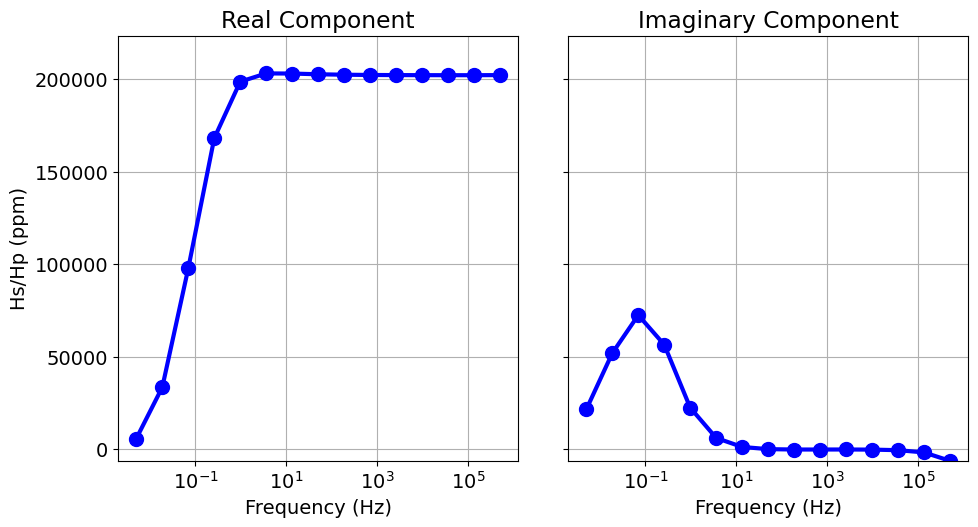

In [81]:
ylim = [np.min(dpred), 1.1 * np.max(dpred)]

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.85])
ax1.semilogx(frequencies, dpred[0::2], "b-o", lw=3, ms=10)
ax1.grid()
ax1.set_ylim(ylim)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.semilogx(frequencies, dpred[1::2], "b-o", lw=3, ms=10)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xlabel("Frequency (Hz)")
ax2.set_yticklabels("")
ax2.set_title("Imaginary Component")

plt.show()